Model Accuracy: 96.39%


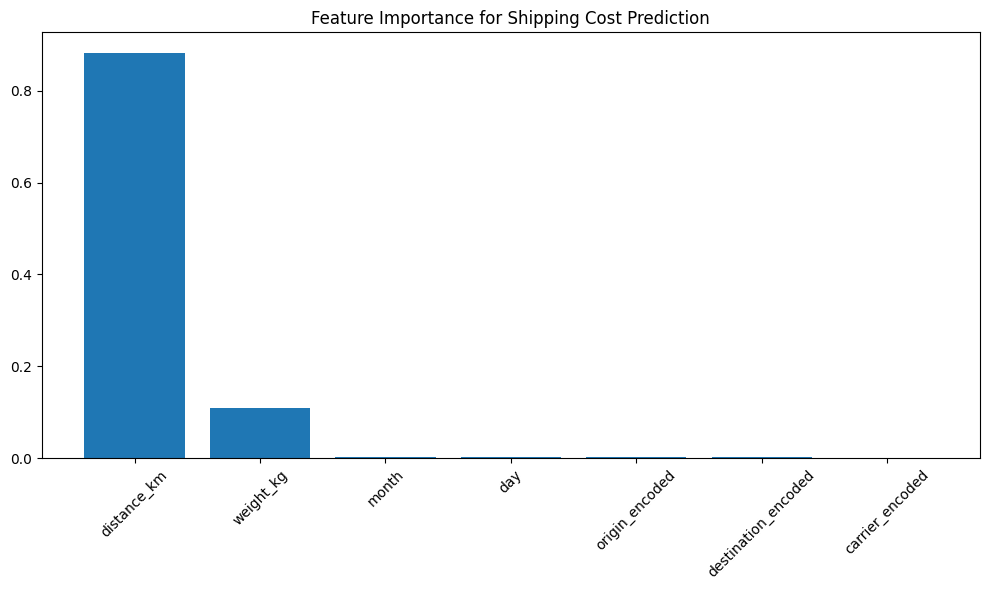


Current Total Shipping Cost: $1685062.92
Optimized Total Shipping Cost: $1157646.62
Potential Savings: $527416.30 (31.30%)


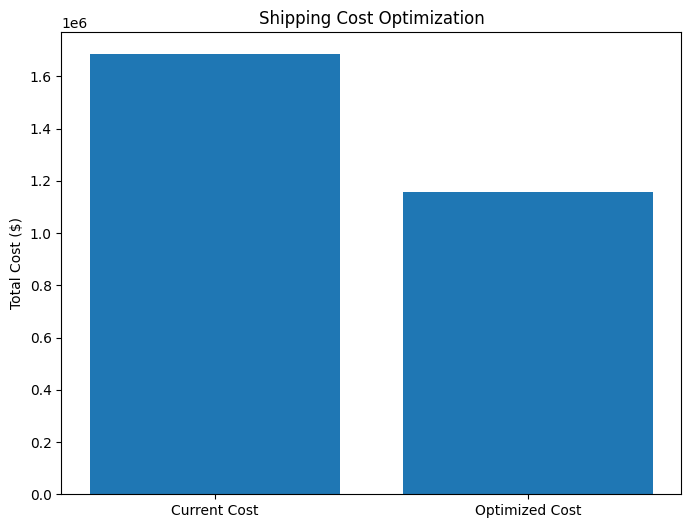


Recommendations:
1. Switch to optimal carriers for each route to achieve immediate cost savings
2. Focus on negotiating better rates for the most expensive routes
3. Consider consolidating shipments to increase weight and reduce cost per kg


In [1]:
# 2_optimization.ipynb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error

# Load the data
data = pd.read_csv('../data/shipping_data.csv')

# Add calculated columns
data['cost_per_km'] = data['shipping_cost'] / data['distance_km']
data['cost_per_kg'] = data['shipping_cost'] / data['weight_kg']

# Convert date to datetime
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day

# Encode categorical variables
le_origin = LabelEncoder()
le_dest = LabelEncoder()
le_carrier = LabelEncoder()

data['origin_encoded'] = le_origin.fit_transform(data['origin'])
data['destination_encoded'] = le_dest.fit_transform(data['destination'])
data['carrier_encoded'] = le_carrier.fit_transform(data['carrier'])

# Prepare features for demand forecasting
features = ['distance_km', 'weight_kg', 'month', 'day', 
            'origin_encoded', 'destination_encoded', 'carrier_encoded']
X = data[features]
y = data['shipping_cost']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a simple model
model = RandomForestRegressor(n_estimators=50, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate accuracy
mae = mean_absolute_error(y_test, y_pred)
accuracy = 1 - (mae / y_test.mean())
print(f"Model Accuracy: {accuracy:.2%}")

# Feature importance
importance = model.feature_importances_
plt.figure(figsize=(10, 6))
plt.bar(features, importance)
plt.title('Feature Importance for Shipping Cost Prediction')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../results/feature_importance.png')
plt.show()

# Optimization analysis
# Find the cheapest carrier for each route
route_carrier_costs = data.groupby(['origin', 'destination', 'carrier'])['shipping_cost'].mean().reset_index()
optimal_carriers = route_carrier_costs.loc[route_carrier_costs.groupby(['origin', 'destination'])['shipping_cost'].idxmin()]

# Calculate potential savings
current_total = data['shipping_cost'].sum()
optimal_routes = pd.merge(data[['origin', 'destination']], 
                          optimal_carriers[['origin', 'destination', 'carrier', 'shipping_cost']], 
                          on=['origin', 'destination'])
optimal_total = optimal_routes['shipping_cost'].sum()
savings = current_total - optimal_total
savings_percent = (savings / current_total) * 100

print(f"\nCurrent Total Shipping Cost: ${current_total:.2f}")
print(f"Optimized Total Shipping Cost: ${optimal_total:.2f}")
print(f"Potential Savings: ${savings:.2f} ({savings_percent:.2f}%)")

# Visualize savings
plt.figure(figsize=(8, 6))
plt.bar(['Current Cost', 'Optimized Cost'], [current_total, optimal_total])
plt.title('Shipping Cost Optimization')
plt.ylabel('Total Cost ($)')
plt.savefig('../results/cost_savings.png')
plt.show()

# Recommendations
print("\nRecommendations:")
print("1. Switch to optimal carriers for each route to achieve immediate cost savings")
print("2. Focus on negotiating better rates for the most expensive routes")
print("3. Consider consolidating shipments to increase weight and reduce cost per kg")
